# Step 1: Data Overview

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv("/content/Gold_Silver_Prediction_Data.csv")

# 1. Shape of the dataset
print("Shape of the data (Rows, Columns):", df.shape)

# 2. Column names
print("\nColumn Names:\n", df.columns.tolist())

# 3. Data types of each column
print("\nData Types:\n", df.dtypes)

# 4. Basic statistics for numerical columns
print("\nBasic Statistics (Numerical):\n", df.describe())

# 5. Basic statistics for categorical columns
print("\nBasic Statistics (Categorical):\n", df.describe(include='object'))

# 6. Check for null values
print("\nNull Values Count:\n", df.isnull().sum())

# 7. Display sample data
print("\nSample Records:\n", df.head())


Shape of the data (Rows, Columns): (8004, 25)

Column Names:
 ['Date', 'Gold_Price_INR', 'Silver_Price_INR', 'Gold_Price_Change', 'Silver_Price_Change', 'USD_INR_Exchange_Rate', 'Global_Gold_Price_USD', 'Global_Silver_Price_USD', 'India_CPI', 'RBI_Repo_Rate', 'Sensex_Index', 'Gold_Volatility_7D', 'Silver_Volatility_7D', 'Gold_Moving_Avg_7D', 'Silver_Moving_Avg_7D', 'Geopolitical_Sentiment', 'Market_Sentiment_Gold', 'Market_Sentiment_Silver', 'Gold_Demand_India', 'Silver_Industrial_Demand', 'Seasonal_Indicator', 'Gold_Price_Next_Day', 'Silver_Price_Next_Day', 'Gold_Price_Movement', 'Silver_Price_Movement']

Data Types:
 Date                         object
Gold_Price_INR              float64
Silver_Price_INR            float64
Gold_Price_Change           float64
Silver_Price_Change         float64
USD_INR_Exchange_Rate       float64
Global_Gold_Price_USD       float64
Global_Silver_Price_USD     float64
India_CPI                   float64
RBI_Repo_Rate               float64
Sensex_Index 

In [ ]:
import numpy as np

# Make a copy to work on
df_cleaned = df.copy()

# ------- Data Cleaning -------

# Convert Date column to datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')

# Remove irrelevant columns (if any) - manually define if known
# For now, assuming no irrelevant columns; otherwise use: df_cleaned.drop(['col1', 'col2'], axis=1, inplace=True)

# Convert categorical object columns if necessary
# We'll check object columns
print("Object Columns:\n", df_cleaned.select_dtypes(include='object').columns.tolist())

# ------- Invalid Nulls (like '@', '-', etc.) ------
invalid_values = ['@', '#', '$', '%', 'Na', '-', 'NA', 'na', 'null']
df_cleaned.replace(invalid_values, np.nan, inplace=True)

# ------- Null Value Handling -------

null_percentage = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100
print("\nNull Percentage per Column:\n", null_percentage)

# Handle based on rules:
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().sum() > 0:
        perc = null_percentage[col]
        if perc < 15:
            # Drop rows
            df_cleaned = df_cleaned[df_cleaned[col].notnull()]
        elif 15 <= perc < 70:
            # Impute
            if df_cleaned[col].dtype == 'object':
                df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
            else:
                df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)
        elif perc >= 75:
            # Drop the column
            df_cleaned.drop(col, axis=1, inplace=True)

# ------- Outlier Treatment --------

# Define function to cap outliers based on IQR
def treat_outliers_with_mean(column):
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mean_val = df_cleaned[column].mean()
    df_cleaned[column] = np.where((df_cleaned[column] < lower) | (df_cleaned[column] > upper),
                                  mean_val, df_cleaned[column])

# Apply to all numerical columns
numeric_cols = df_cleaned.select_dtypes(include=np.number).columns
for col in numeric_cols:
    treat_outliers_with_mean(col)

# Final cleaned shape
print("\nCleaned Data Shape:", df_cleaned.shape)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')
plt.figure(figsize=(10, 5))

# Plot for numerical columns
numeric_cols = df_cleaned.select_dtypes(include='number').columns

for col in numeric_cols[:5]:  # limit to first 5 for readability
    plt.figure(figsize=(8, 4))
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram & KDE for {col}')
    plt.show()

# Plot for categorical columns
cat_cols = df_cleaned.select_dtypes(include='object').columns

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_cleaned, x=col)
    plt.title(f'Count Plot for {col}')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# Numerical vs Numerical (scatter plot)
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Gold_Price_INR', y='Silver_Price_INR', data=df_cleaned)
plt.title("Gold vs Silver Price")
plt.show()

# Categorical vs Numerical (bar plot)
plt.figure(figsize=(8, 5))
sns.barplot(x='Seasonal_Indicator', y='Gold_Price_INR', data=df_cleaned)
plt.title("Gold Price vs Season")
plt.show()


In [ ]:
# Correlation matrix for numerical features
plt.figure(figsize=(14, 10))
corr = df_cleaned[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


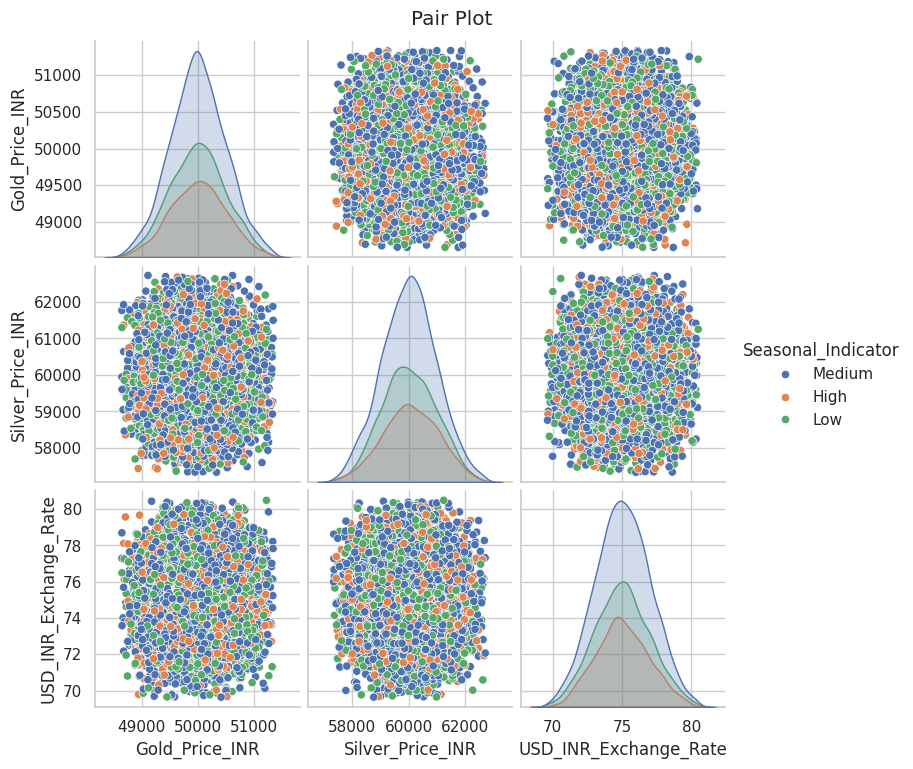

In [ ]:
# Pair plot with 3 features and hue
sns.pairplot(df_cleaned, vars=["Gold_Price_INR", "Silver_Price_INR", "USD_INR_Exchange_Rate"],
             hue="Seasonal_Indicator")
plt.suptitle("Pair Plot", y=1.02)
plt.show()


In [ ]:
# Set target column
target = 'Gold_Price_Movement'

# Separate X and y
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target column
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Drop the 'Date' column before scaling as it's not numerical
X_encoded = X_encoded.drop(columns=['Date'])

# Scale the numerical features
X_scaled = scaler.fit_transform(X_encoded)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (6399, 25)
Testing shape: (1600, 25)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.983125

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       586
           1       0.97      0.98      0.97       485
           2       1.00      0.98      0.99       529

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


Confusion Matrix:
 [[579   7   0]
 [  8 475   2]
 [  0  10 519]]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# R² Score
print("R² Score:", r2_score(y_test, y_pred))

# RMSE using manual sqrt
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


R² Score: 0.9757405723764861
RMSE: 0.1299038105676658


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize model
logreg = LogisticRegression(max_iter=1000)

# K-Fold Cross Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with Cross Validation
grid_search = GridSearchCV(logreg, param_grid, cv=cv, scoring='f1_macro')  # for multiclass F1
grid_search.fit(X_train, y_train)

# Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated F1 Score:", grid_search.best_score_)

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Best Cross-Validated F1 Score: 0.9808091952231146

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       586
           1       0.98      0.98      0.98       485
           2       0.99      0.99      0.99       529

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.99      0.98      0.99      1600



In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Parameter grid
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

# Initialize regressor
rf = RandomForestRegressor(random_state=42)

# Grid Search with Cross Validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_root_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

# Best Parameters and Score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best RMSE (CV):", -grid_search_rf.best_score_)


Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best RMSE (CV): 0.06296759937173954


In [ ]:
# Remove the 'Date' column
df_cleaned = df.drop(columns=['Date'])

# Check the new shape
print("Updated DataFrame Shape:", df_cleaned.shape)


Updated DataFrame Shape: (8004, 24)


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Load and clean data
df_cleaned = df.drop(columns=['Date'])

# Target and features
target = 'Gold_Price_Movement'
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Impute missing values (numerical strategy = mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# RFE with Logistic Regression
model = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_scaled, y_encoded)

# Show top selected features
selected_features = X_encoded.columns[rfe.support_].tolist()
print("Top 10 Selected Features by RFE:")
print(selected_features)


Top 10 Selected Features by RFE:
['Gold_Price_INR', 'Gold_Price_Change', 'Silver_Price_Change', 'Gold_Moving_Avg_7D', 'Gold_Price_Next_Day', 'Silver_Price_Next_Day', 'Seasonal_Indicator_Low', 'Seasonal_Indicator_Medium', 'Silver_Price_Movement_Stable', 'Silver_Price_Movement_Up']
